In [50]:
### setup
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,6)

In [51]:
from main import nlp_pipeline_result

In [52]:
"""
data_non_ner = nlp_pipeline_result(
    parser_parameters={
        "remove_hashtag_word": True,
        "replace_politics": True,
        "replace_parties": True,
    },
    nlp_parameters={
        "disable_parser": False,
        "disable_ner": False
    }
)
data_non_ner['n_lemmas'] = data_non_ner['Lemmas'].str.split().str.len()

data_non_ner.to_csv('data/data.csv', index = False)
"""

'\ndata_non_ner = nlp_pipeline_result(\n    disable_ner=False,\n    parameters={\n        "remove_hashtag_word": True,\n        "replace_politics": True,\n        "replace_parties": True,\n    }\n)\ndata_non_ner[\'n_lemmas\'] = data_non_ner[\'Lemmas\'].str.split().str.len()\n\ndata_non_ner.to_csv(\'data/data.csv\', index = False)\n'

In [68]:
data = pd.read_csv('data/data.csv')


In [71]:
data['Madrid' in data['Lemmas'].str | 'Madrid' in data['Lemmas'].str].count()

TypeError: unsupported operand type(s) for |: 'StringMethods' and 'str'

In [54]:


train = data.sample(frac = 0.8, random_state = 420)
test = data.drop(train.index)

print("Len data: ", len(data))
print("Len train: ", len(train))
print("Len test: ", len(test))


data = train

Len data:  14789
Len train:  11831
Len test:  2958


In [55]:
for i in range(0,50,10):
    display(data[i:i+10])

,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
12772,@cristian91tf @Macarena_Olona @Santi_ABASCAL @...,Y conste que había visto el perfil de boxeador...,2,0,Víctor Manuel Sánchez del Real,Vox,conste ver perfil boxeador respuesta ver encaj...,8
13437,Buena movilización con @psoecoslada @Angvivero...,Buena movilización con José Sousa votamos gana...,133,60,Rafael Simancas Simancas,PSOE,movilización José Sousa votar ganar gobernamos,6
5151,En el capítulo de hoy de #MatemáticasParaProgr...,En el capítulo de hoy de 🤦🏼‍♂️ ya la desespera...,5450,1764,Iván Espinosa de los Monteros de Simón,Vox,capítulo desesperación,2
9379,@Pereira_Hugo_ Pues a mi me interesa mucho los...,Pues a mi me interesa mucho los motivos por lo...,43,4,María Muñoz Vidal,Ciudadanos,interesar motivo decir hacer él competencia Mo...,10
7466,"Otro nuevo asesinato machista, otra vida trunc...",Otro nuevo asesinato machista otra vida trunca...,11,11,Fuensanta Lima Cid,PSOE,asesinato machista vida truncado vida arrebata...,14
10771,@sanchezcastejon 🗣 Alcanzamos una nueva meta:✔...,🗣 Alcanzamos una nueva meta:✔5 millones de per...,2,1,Ana Prieto Nieto,PSdeG-PSOE,alcanzar millón persona pauta completo millón ...,16
2200,@xiscorana @manuelcheda No te considero enemig...,No te considero enemigo en absoluto Y comparto...,1,0,Pilar Cancela Rodríguez,PSdeG-PSOE,considerar enemigo absoluto compartir joroba,5
1989,La revista @idees_cat me pidió una contribució...,La revista me pidió una contribución al debate...,12,6,Albert Botran Pahissa,CUP-PR,revista pedir contribución debate independenti...,16
9495,@VOX_Caceres resume parte de la semana en el @...,resume parte de la semana en el No dimos ni da...,31,17,María Magdalena Nevado del Campo,Vox,resumir semana dar dar yo jama paso Feliz semana,9
4042,Hoy he estado recorriendo distintos colegios e...,Hoy he estado recorriendo distintos colegios e...,133,29,Emilio Jesús Del Valle Rodríguez,Vox,recorrer colegio electoral Madrid apoyar apode...,7


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
12515,Dos opciones: 1)Dado que TODOS compartimos anc...,Dos opciones: 1)Dado que TODOS compartimos anc...,1052,359,Víctor Manuel Sánchez del Real,Vox,opción compartir ancestro Lucy famoso Australo...,16
3749,"Por cierto, mi disertación sobre que el cambio...",Por cierto mi disertación sobre que el cambio ...,120,39,Francisco José Contreras Peláez,Vox,disertación cambio climático problema grave hu...,14
703,Apología de un parido con una trayectoria crim...,Apología de un parido con una trayectoria crim...,55,20,Francisco José Alcaraz Martos,Vox,apología parido trayectoria criminal boca Gobi...,8
7277,Lo haremos con el arma más poderosa VOTANDO,Lo haremos con el arma más poderosa VOTANDO,3,3,Rafael José Vélez,PSOE,hacer arma poderoso votando,4
3651,Esto sí que es (auto)maltrato de la mujer. Y d...,Esto sí que es (auto)maltrato de la mujer Y de...,18,12,Francisco José Contreras Peláez,Vox,mujer candidata Vox Madrid,4
12713,"Efectivamente, los compañeros y el jefe de Mat...",Efectivamente los compañeros y el jefe de Matu...,582,260,Víctor Manuel Sánchez del Real,Vox,compañero jefe Matute microbús Dolorosamente m...,10
12963,La cadena pública BBC.,La cadena pública BBC,92,24,Víctor Manuel Sánchez del Real,Vox,cadena público BBC,3
8173,@jfalbertos @gonzalezferriz @_ignaciomolina @m...,Yo q también ando citado en el libro sin idea ...,6,0,Pau Mari Klose,PSOE,q ar citado libro idea clarísimo q desacuerdo ...,23
478,Segundo café. La mentira es su divisa a travé...,Segundo café La mentira es su divisa a través de,18,9,Francisco José Alcaraz Martos,Vox,café mentira divisa,3
12095,Recordar y expresar el daño que hizo cierta eq...,Recordar y expresar el daño que hizo cierta eq...,2684,543,Gabriel Rufián Romero,ERC-S,Recordar expresar daño equidistancia izquierda...,16


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
8005,Hoy es jornada de reflexión. Les propongo refl...,Hoy es jornada de reflexión Les propongo refle...,10,7,Pilar Marcos Domínguez,PP,jornada reflexión proponer reflexionar reflexi...,7
12205,"Gallardón, Aguirre, Cifuentes, Ayuso... #TodaU...",Gallardón Aguirre Cifuentes Ayuso de políticas...,196,81,Inés Sabanés Nadal,Más País-Equo,Gallardón Aguirre Cifuentes Ayuso política inj...,10
9412,Estremecedoras imágenes de violencia ayer en V...,Estremecedoras imágenes de violencia ayer en V...,2,1,Carmen Navarro Lacoba,PP,Estremecedoras imagen violencia VallecasO refl...,10
211,La Comisión de Transición Ecológica y Reto Dem...,La Comisión de Transición Ecológica y Reto Dem...,5,3,José Luis Aceves Galindo,PSOE,Comisión Transición Ecológica Reto Demografico...,13
3707,@_InakiLopez_ Y tú eres un mentiroso a sueldo....,Y tú eres un mentiroso a sueldo Dije q el camb...,5,2,Francisco José Contreras Peláez,Vox,mentiroso sueldo decir q cambio climático tene...,27
4715,Tienes derecho a ausentarte del trabajo para i...,Tienes derecho a ausentarte del trabajo para i...,5764,1461,Íñigo Errejón Galván,Más País-Equo,tener derecho ausentarte votar reducción sueld...,16
10690,Esta mañana hemos denunciado que mientras se i...,Esta mañana hemos denunciado que mientras se i...,81,46,Víctor Valentín Píriz Maya,PP,mañana denunciar inviertar millón salvar aerol...,17
10480,Lo que pasa cuando votas socialismo. Y lo que ...,Lo que pasa cuando votas socialismo Y lo que p...,63,26,Víctor Valentín Píriz Maya,PP,pasar votar socialismo pasar votar Libertad,6
5218,"En Cataluña, los legisladores se saltan la Ley...",En Cataluña los legisladores se saltan la LeyI...,946,525,Iván Espinosa de los Monteros de Simón,Vox,Cataluña legislador saltar leyizquierda separa...,18
11003,"@JosRosaRodrgue2 ¡José, de ese pueblo es origi...",¡José de ese pueblo es originaria la familia d...,5,2,José Ramírez del Río,Vox,José pueblo originario familia mujer alegrar vero,7


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
8951,"Contigo, querida @MazelLilith, somos una piña",Contigo querida somos una piña,1384,305,Irene María Montero Gil,Unidas Podemos,querido piña,2
8986,También con @empleoGob por primera vez pondrem...,También con por primera vez pondremos en march...,188,52,Irene María Montero Gil,Unidas Podemos,poner marcha Plan Inserción social laboral muj...,18
5938,Cada vez que dono sangre y la sala de extracci...,Cada vez que dono sangre y la sala de extracci...,6,0,Valentín García Gómez,PSOE,donar sangre sala extracción lleno sentir orgu...,10
10039,Como Diputado Nacional por la provincia de Cád...,Como Diputado Nacional por la provincia de Cád...,11,1,José Ortiz Galván,PP,Diputado Nacional provincia Cádiz traslado pés...,22
559,Sánchez donará en su nombre pero con el dinero...,Sánchez donará en su nombre pero con el dinero...,147,87,Francisco José Alcaraz Martos,Vox,Sánchez donar nombre dinero español saquear bo...,10
6243,Con @fjosealcaraz en la comisión de seguridad ...,Con en la comisión de seguridad vial y tráfico...,131,36,Luis Gestoso de Miguel,Vox,comisión seguridad vial tráfico Congreso oponi...,15
12965,"Gabilondo y su “descampao” intelectual, y tamb...",Gabilondo y su “descampao” intelectual y tambi...,628,199,Víctor Manuel Sánchez del Real,Vox,Gabilondo descampao intelectual,3
4460,"Tras el 4M toca escuchar con calma, especialme...",Tras el 4M toca escuchar con calma especialmen...,239,89,Odón Elorza González,PSE-EE-PSOE,M tocar escuchar calma análisis comentario ele...,22
239,Iglesias y Redondo pactaron reventar la campañ...,Iglesias y Redondo pactaron reventar la campañ...,82,58,Juan José Aizcorbe Torra,Vox,Iglesias Redondo pactar reventar campaña elect...,9
1409,@DaniGagoPhoto Un abrazo grande @DaniGagoPhoto...,Un abrazo grande Toda nuestra solidaridad Grac...,57,7,Jaume Asens Llodrà,En Comú Podem,abrazo grande solidaridad gracias cámara,5


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
5871,Los partidos que hicieron la moción de censura...,Los partidos que hicieron la moción de censura...,348,124,Teodoro García Egea,PP,partido moción censura fallido perjudicado PSO...,12
4879,Valoramos @Rita_Maestre y yo el debate: ya lle...,Valoramos y yo el debate: ya llegábamos a él s...,756,132,Íñigo Errejón Galván,Más País-Equo,valorar debate llegábar subir encuesta salir c...,7
6474,@guillermomeijon @anaprietonieto @uxia_tizon @...,PSOE Me alegro que te haya gustado querido Gui...,0,0,Miguel Ángel González Caballero,PSOE,PSOE alegrar gustar querido Guillermo,5
11970,"Mirando el culote, puede conocerse la proceden...",Mirando el culote puede conocerse la procedenc...,1124,379,Agustín Rosety Fernández de Castro,Vox,mirar culote conocer él procedencia año analiz...,22
6842,Me representa. #YoConAyuso,Me representa,14,4,José Alberto Herrero Bono,PP,representar,1
14706,VOX es el nuevo Palmar de Troya:Odio a la izqu...,Vox es el nuevo Palmar de Troya:Odio a la izqu...,454,177,José Zaragoza Alonso,PSC,Vox Palmar Troya odiar izquierda Defensa franq...,9
5059,Quizá no estés de acuerdo en todo lo anterior....,Quizá no estés de acuerdo en todo lo anterior ...,2941,628,Iván Espinosa de los Monteros de Simón,Vox,importar increíble diario programa tv radio en...,14
2661,La organización de la libertad @NNGG_Es @popul...,La organización de la libertad PP Un honor hab...,58,11,Eduardo Carazo Hermoso,PP,organización libertad PP honor presidir Comité...,7
9800,La Audiencia de A Coruña hoy ha hecho grande n...,La Audiencia de A Coruña hoy ha hecho grande n...,1873,692,Macarena Olona Choclán,Vox,Audiencia Coruña grande Democracia imponer igu...,17
2673,Mi artículo en @ElHuffPost'No se puede dejar s...,Mi artículo en se puede dejar sin respuesta ni...,8,10,Beatriz Micaela Carrillo de los Reyes,PSOE,artículo dejar respuesta afirmación derecha es...,15


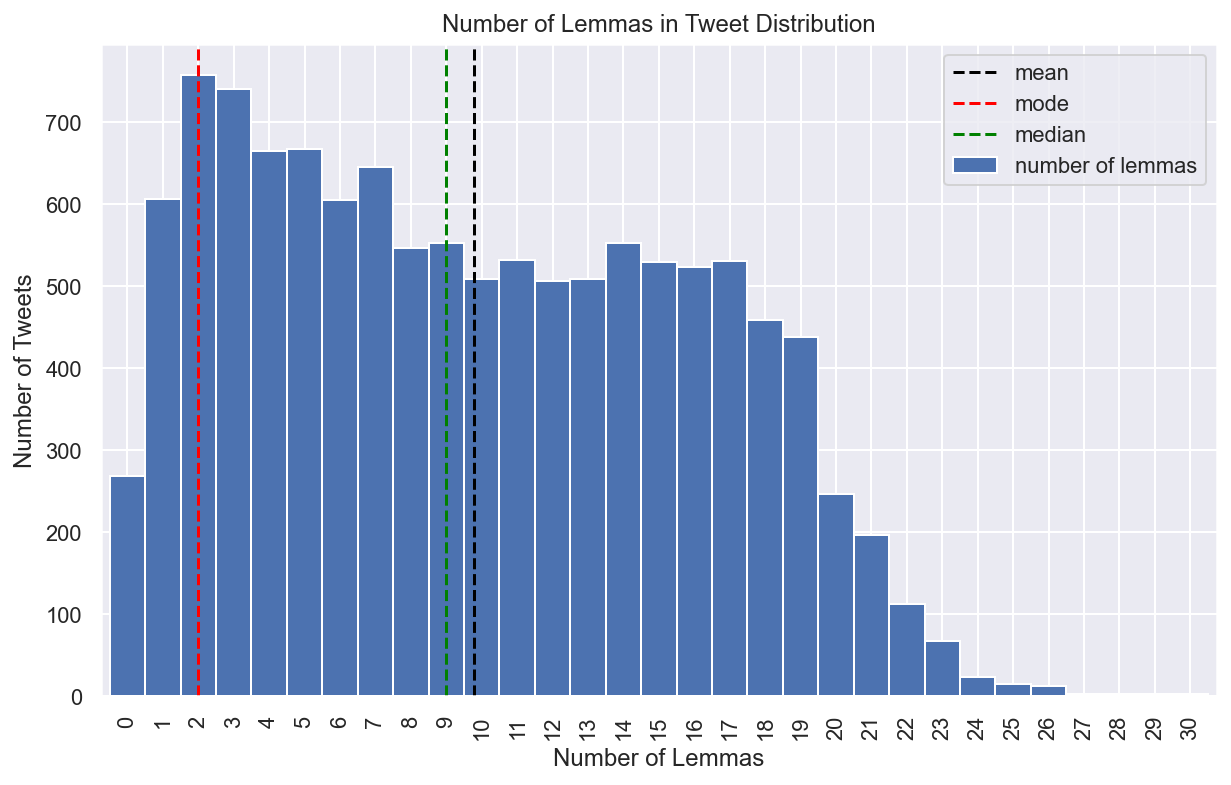

In [56]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar",width=1,label='number of lemmas')
plt.axvline(x = data['n_lemmas'].mean(),label='mean',color = 'black',linestyle = '--')
plt.axvline(x = data['n_lemmas'].mode()[0],label='mode',color = 'red',linestyle = '--')
plt.axvline(x = data['n_lemmas'].median(),label='median',color = 'green',linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [57]:
data = data[data['n_lemmas']>=3]
print('Number of Tweets in Dataframe after removing short tweets:', len(data))

Number of Tweets in Dataframe after removing short tweets: 10198


In [58]:
tweets_corpus = data["Lemmas"].tolist()
# tweets_corpus = list(set(tweets_corpus))
tweets_corpus = [el.split() for el in tweets_corpus]

# display(tweets_corpus)

In [59]:
from gensim.corpora import Dictionary

token_dic = Dictionary(tweets_corpus)


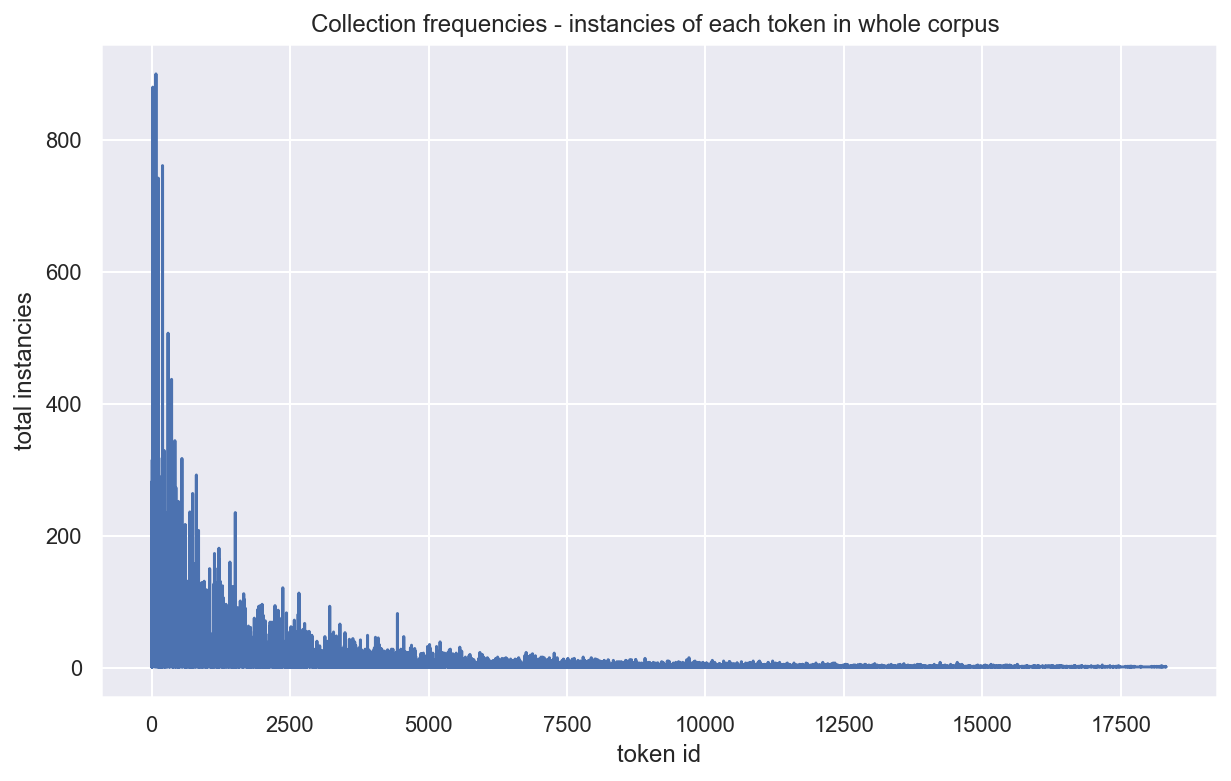

Max of occurances per topic:  900
Mean of occurances per topic:  6.202652548848379


In [60]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.

collfreq = token_dic.cfs.items()
collfreq = sorted(collfreq) 
x, y = zip(*collfreq) 
plt.plot(x, y)
plt.title('Collection frequencies - instancies of each token in whole corpus ')
plt.xlabel('token id')
plt.ylabel('total instancies')
plt.show()



# MEAN

count = 0
_sum = 0
for key in token_dic.cfs:
    count += 1
    _sum += token_dic.cfs[key]

instances_mean = _sum/count



#MAX

instances_max = max(token_dic.cfs.values())





print("Max of occurances per topic: ",instances_max )
print("Mean of occurances per topic: ",instances_mean )






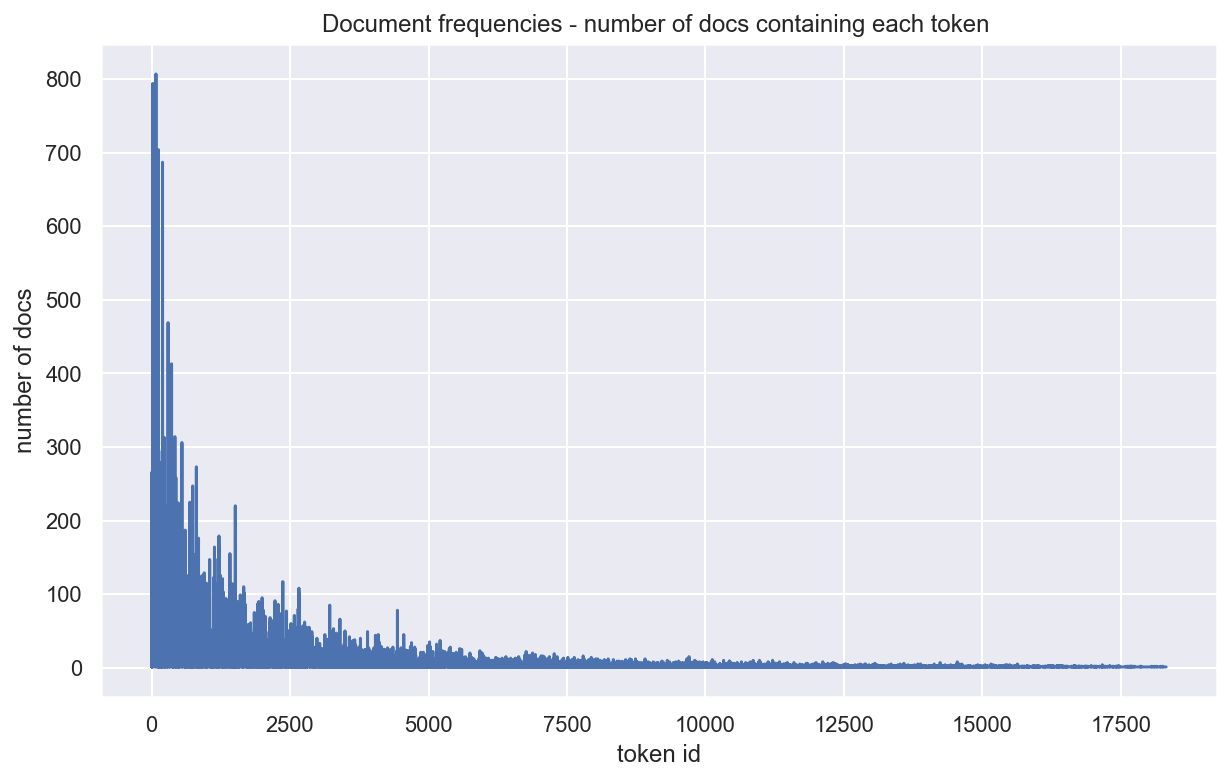

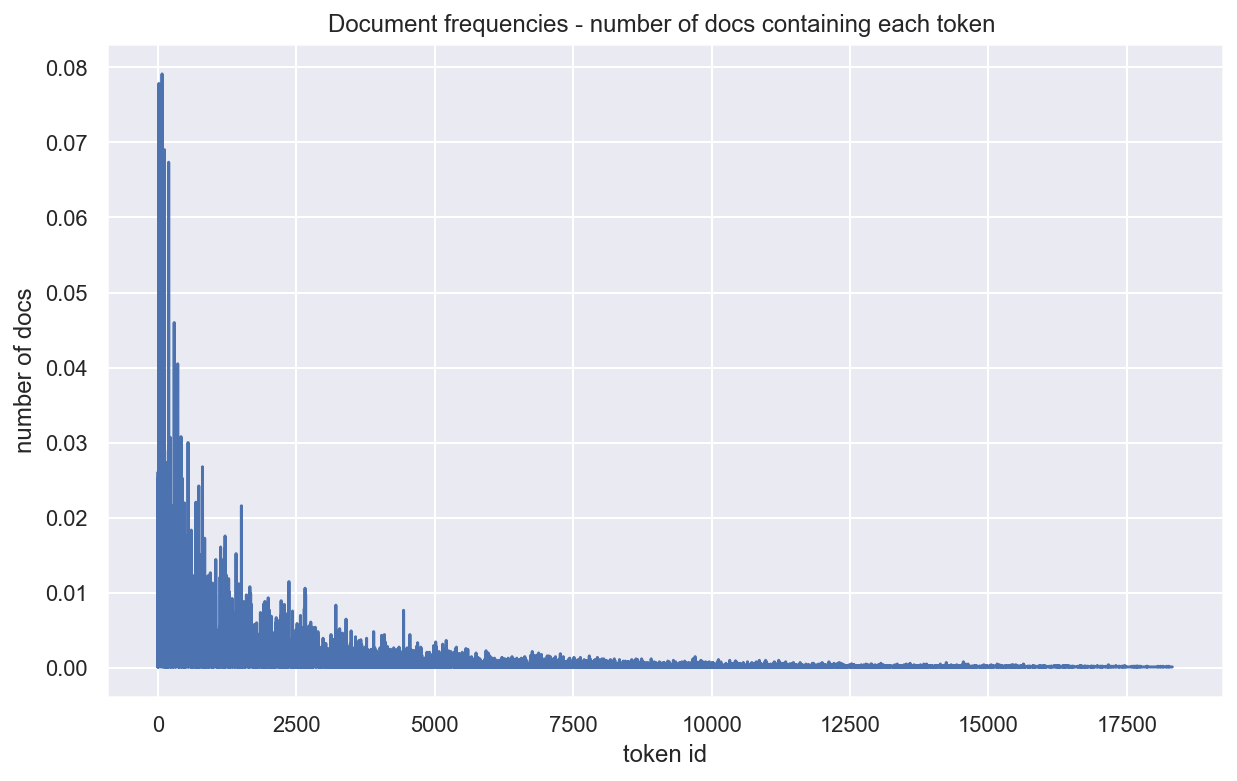

Max of docs in which a token appears:  807
Mean of docs in which token appears:  5.997052723501801


In [61]:
# Document frequencies: token_id -> how many documents contain this token


docfreq = token_dic.dfs.items()
docfreq = sorted(docfreq) 
j, k = zip(*docfreq) 
plt.plot(j, k)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')

plt.figure()
plt.plot(np.array(j), np.array(k)/len(data))
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()



# MEAN

count = 0
_sum = 0
for key in token_dic.dfs:
    count += 1
    _sum += token_dic.dfs[key]

docs_mean = _sum/count



#MAX

docs_max = max(token_dic.dfs.values())





print("Max of docs in which a token appears: ",docs_max )
print("Mean of docs in which token appears: ",docs_mean )



In [62]:
#FILTER TOKEN DICTIONARY




no_below_list = [1,2,3,4,5,6,7,8,9,10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [.5, .4, .3, .2, .05, .04, .03, .02, .005, .004, .003, .002, .0005, .0004, 0.0003, .0002] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

prev_dic = copy.copy(token_dic)
prev_tokens = len(token_dic)


# print('The dictionary contained', prev_tokens, 'terms')

# for i in no_below_list:
    
#     for j in no_above_list:
        
#         token_dic = Dictionary(tweets_corpus)
        
#         token_dic.filter_extremes(no_below=i,no_above=j)
        
#         n_tokens = len(token_dic)
        
#         print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY



In [63]:
token_dic.filter_extremes(no_below=2,no_above=1)
# for n in range(500):
#     print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

print('The dictionary contains', len(token_dic), 'terms')


The dictionary contains 7746 terms


In [64]:

#print(list(token_dic.values()))
"Madrid" in token_dic.values()



True

In [65]:

# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

# tweets_corpus_bow

In [66]:
from gensim.models.wrappers import LdaMallet
import os

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

num_topics = 10
ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=num_topics,
    id2word=token_dic,
    alpha=5,
    iterations=100
)

IndexError: index 10 is out of bounds for axis 0 with size 10

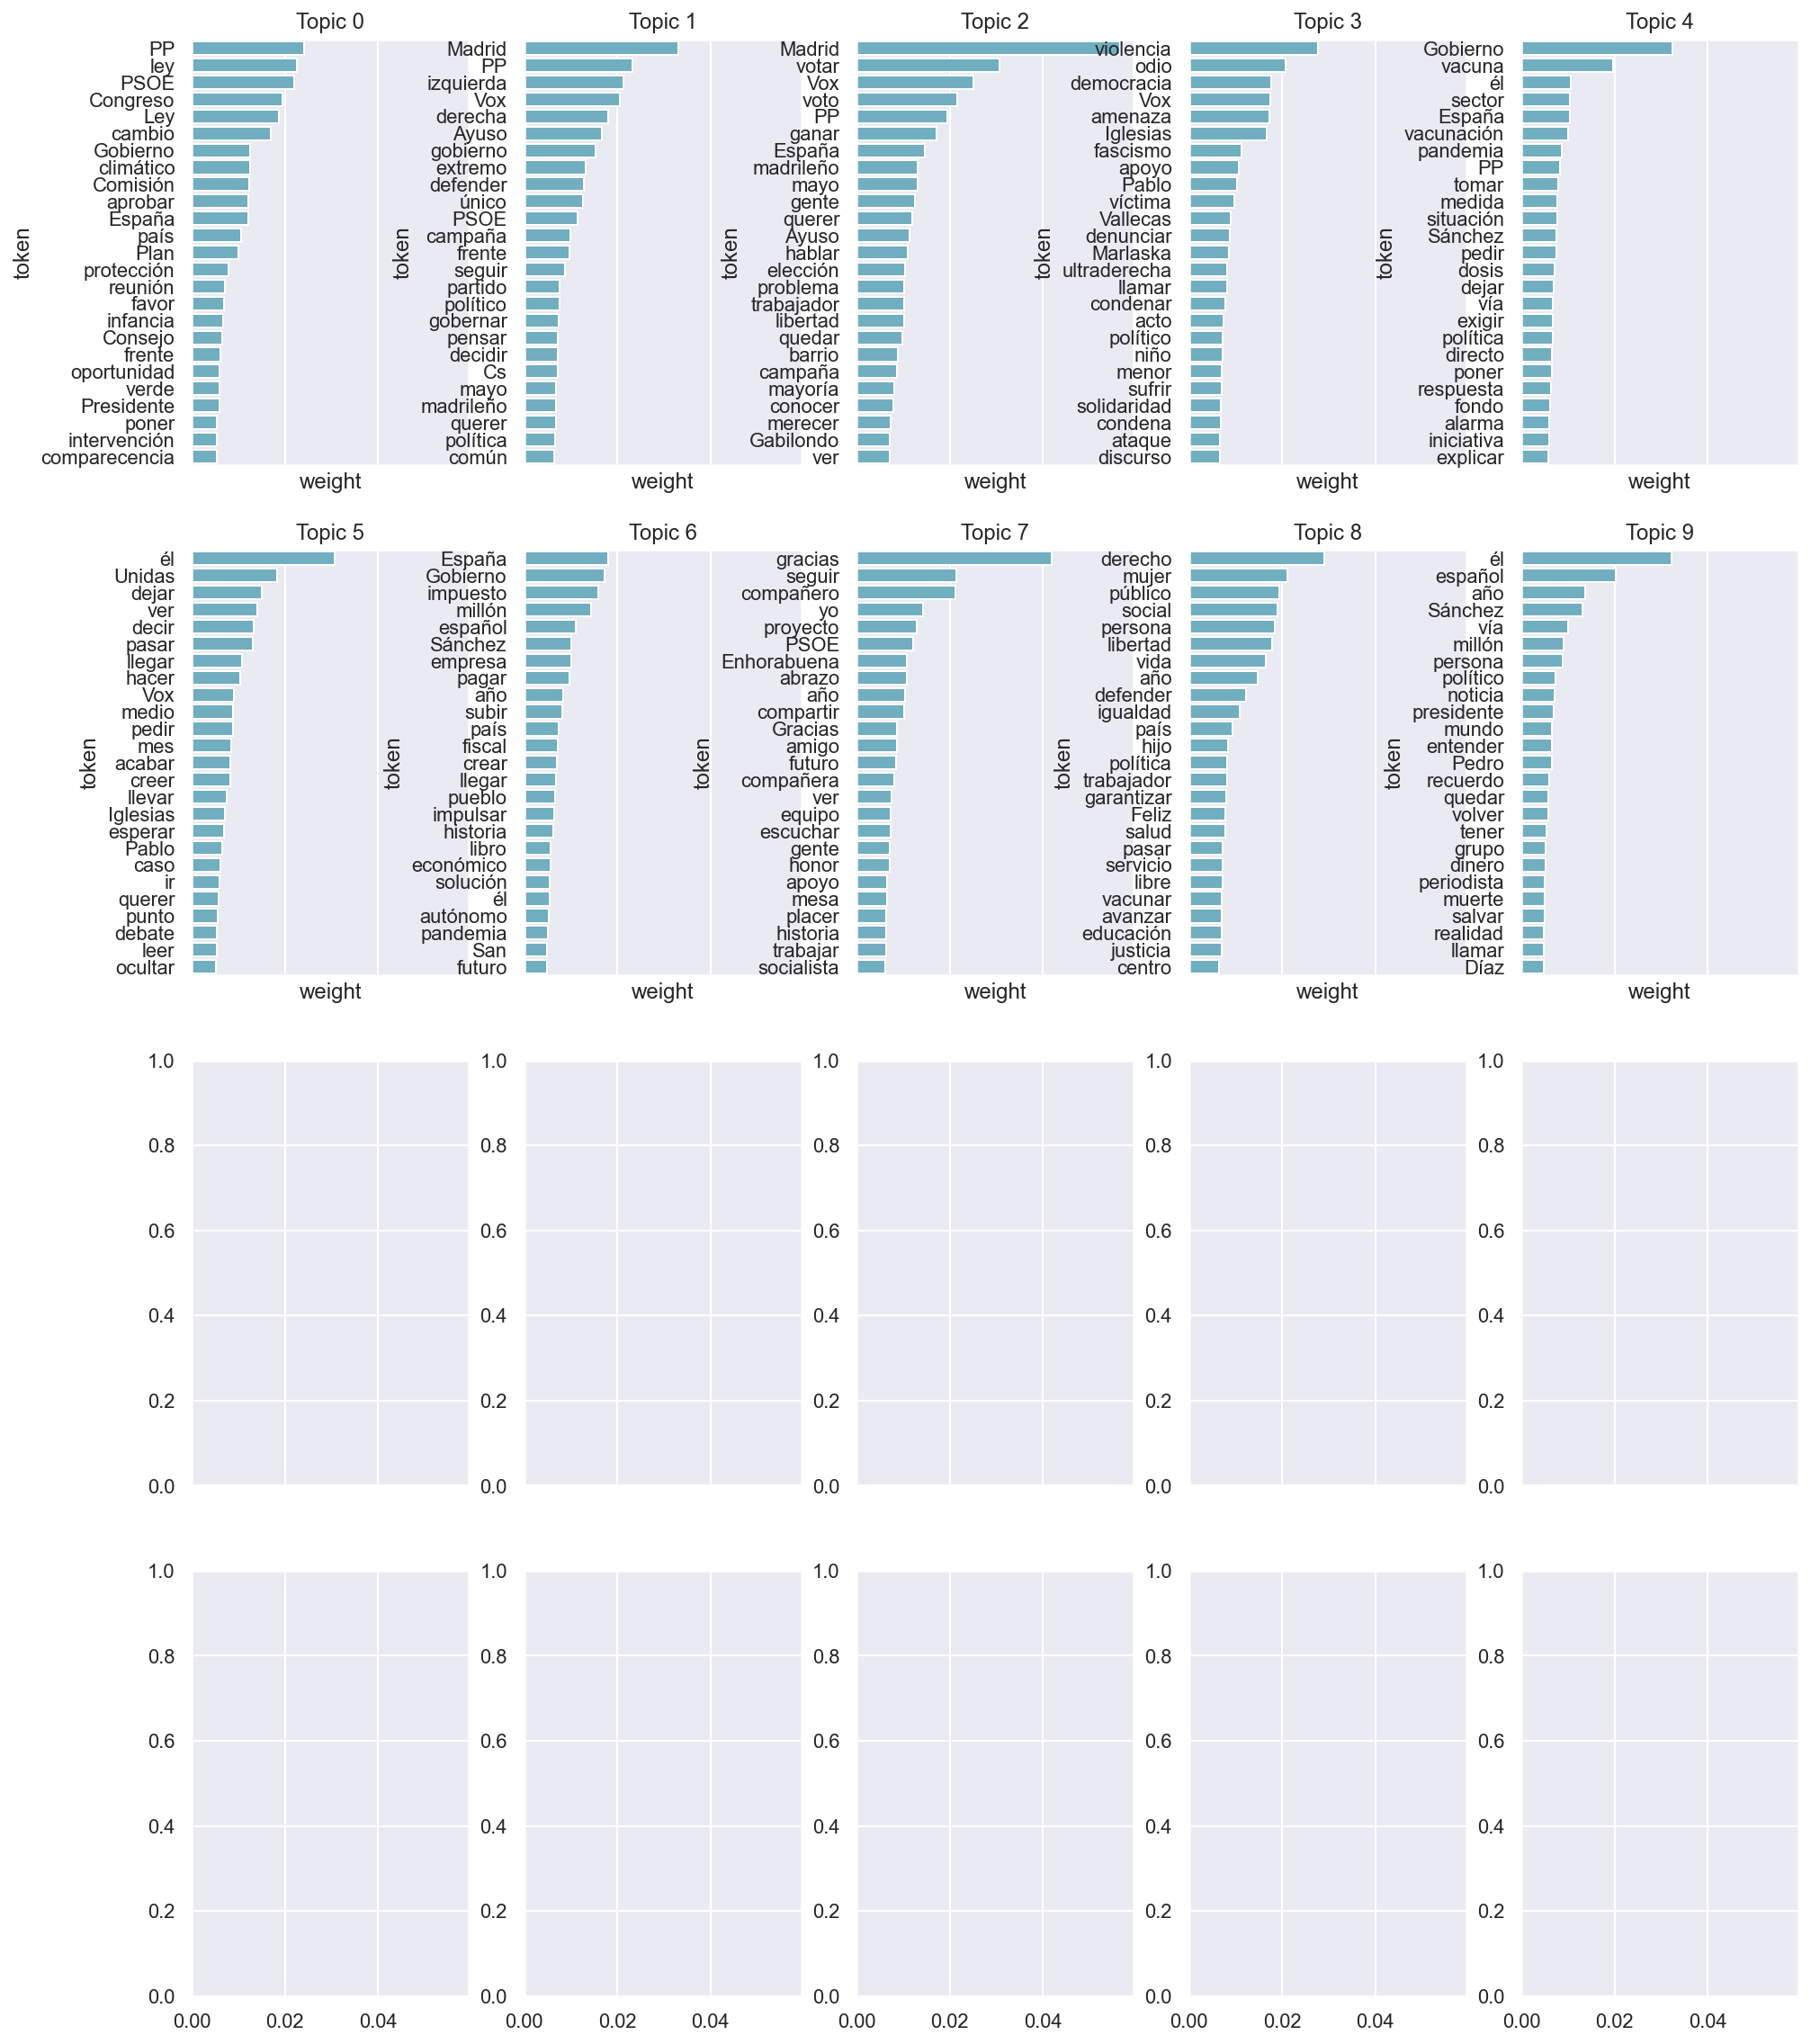

In [67]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)


for i in range(4):
    for j in range(5):
        df = pd.DataFrame(ldamallet.show_topic(j + 5*(i%5), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title('Topic ' + str(j + 5*(i%5)))

    
plt.show()

In [ ]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))


rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df), len(data))


df['Likes'] = data.sort_index()["Likes"].to_list()
df['Retweets'] = data.sort_index()["Retweets"].to_list()
df["Party"] = data.sort_index()["Party"].to_list()
df["Author"] = data.sort_index()["Author"].to_list()
df